In [10]:
from ff_energy.ffe.slurm import SlurmJobHandler
from pathlib import Path
import pandas as pd
import jax.numpy as jnp
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from ff_energy.ffe.potential import (
    LJ,
    DE,
)

from ff_energy.ffe.ff import FF

from ff_energy.plotting.ffe_plots import plot_energy_MSE, plot_ff_fit
from ff_energy.plotting.plotting import set_style

import scienceplots

set_style(no_latex=True)

from ff_energy.ffe.ff_fit import (
    load_ff,
    fit_func,
    fit_repeat,
)

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, PKL_PATH
from ff_energy.utils.json_utils import load_json

structure_data = {
    "dcm": "",
    "water_cluster": PKL_PATH / "20230823_water_clusters.pkl.pkl",
}

"""
Variables
"""
sig_bound = (0.001, 2.5)
ep_bound = (0.001, 2.5)
chg_bound = (100, 2000)
CHGPEN_bound = [(chg_bound), (chg_bound), (chg_bound), (chg_bound), (0, 2000)]
LJ_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound))
DE_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound), (1, 8), (6, 20))

NFIT_COUL = 1
NFIT_LJ = 4
NFIT_DE = 6

pkl_files = []
json_object = load_json("exp1.json")
#  make a product of all the values in the json object
experiments = list(it.product(*json_object.values()))
print(f"N experiments: {len(experiments)}")

N experiments: 6


In [11]:
experiments

[('pbe0dz', 'water_cluster', 'ELECnull', 'lj'),
 ('pbe0dz', 'water_cluster', 'ELECci', 'lj'),
 ('pbe0dz', 'water_cluster', 'ELECpol', 'lj'),
 ('pbe0dz', 'water_cluster', 'ELECk', 'lj'),
 ('pbe0dz', 'water_cluster', 'ELECm', 'lj'),
 ('pbe0dz', 'water_cluster', 'ELECp', 'lj')]

In [12]:
fitted_ = {_.stem: pd.read_pickle(_) for _ in list(PKL_PATH.glob("*fitted*"))}

In [13]:
fitkeys = list(fitted_.keys())
fitkeys

['ELECnull_water_cluster_lj_fitted',
 'ELECci_water_cluster_lj_fitted',
 'ELECpol_water_cluster_lj_fitted',
 'ELECk_water_cluster_lj_fitted',
 'ELECm_water_cluster_lj_fitted',
 'ELECp_water_cluster_lj_fitted']

DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = '/cluster/home/boittier/miniforge3/envs/pycharmm/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf'
2023-09-04 10:34:33 | DEBUG | backend_pdf:fontName:943 - Assigning font /F1 = '/cluster/home/boittier/miniforge3/envs/pycharmm/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf'
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F2 = '/cluster/home/boittier/miniforge3/envs/pycharmm/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf'
2023-09-04 10:34:33 | DEBUG | backend_pdf:fontName:943 - Assigning font /F2 = '/cluster/home/boittier/miniforge3/envs/pycharmm/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /cluster/home/boittier/miniforge3/envs/pycharmm/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf.
2023-09-04 10:34:33 | DEBUG | backend_pdf:writeFonts:989 - Embedding font /cluster

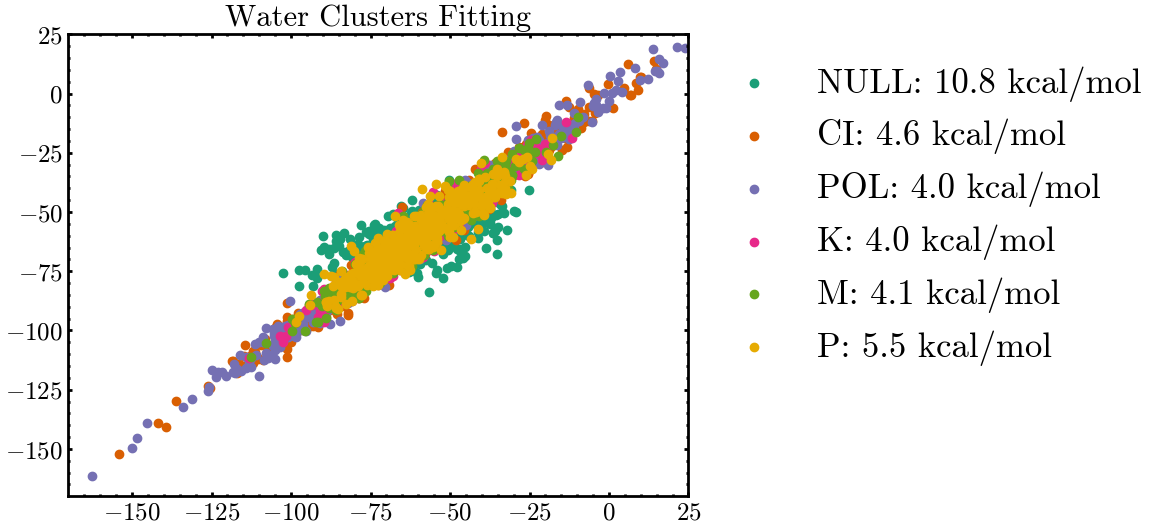

In [118]:
I = 1

for I in range(6):
    key = fitkeys[I]

    results = [_.fun for _ in fitted_[key].opt_results]
    data_vals = [_ for _ in fitted_[key].opt_results_df]
    parm_vals = [_.x for _ in fitted_[key].opt_results]
    dataframe = pd.DataFrame(fitted_[key].opt_results)
    dataframe["values"] = data_vals

    elec = fitted_[key].df[fitted_[key].elec] 
    targets = fitted_[key].targets 
    best = dataframe["fun"].sort_values().index[0]
    
    # print(key, dataframe.fun.min() **0.5, dataframe.iloc[best])
    
    vals = data_vals[best]
    RMSE = dataframe.fun.min() **0.5
    labelkey = f"{key.replace('_', ' ').strip('ELEC').split()[0].upper()}: {RMSE :.1f} kcal/mol"
    
    plt.scatter(targets+elec, vals+elec, label=labelkey)

plt.legend(bbox_to_anchor=(1,1), fontsize=25)
plt.title("Water Clusters Fitting")
plt.xlim(-170, 25)
plt.ylim(-170, 25)
plt.savefig("water_clusters.pdf")

In [64]:
fitted_[key].elec

'ELECci'

In [78]:
# data_vals[0]

array([[<AxesSubplot: title={'center': 'fun'}>]], dtype=object)

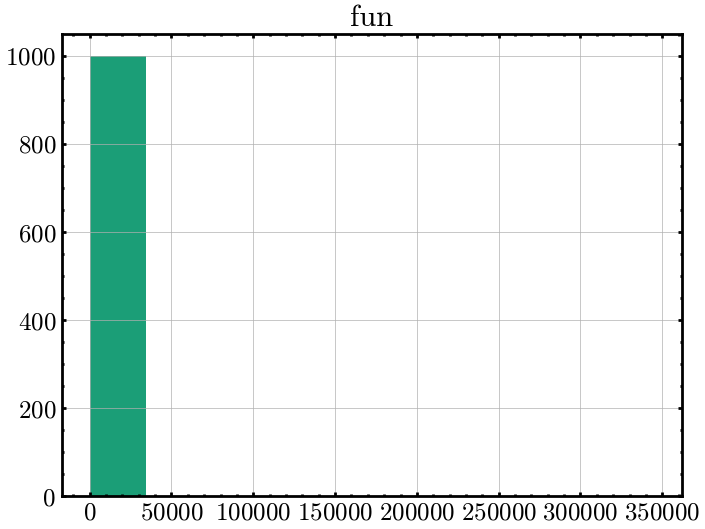

In [61]:
dataframe.hist("fun")

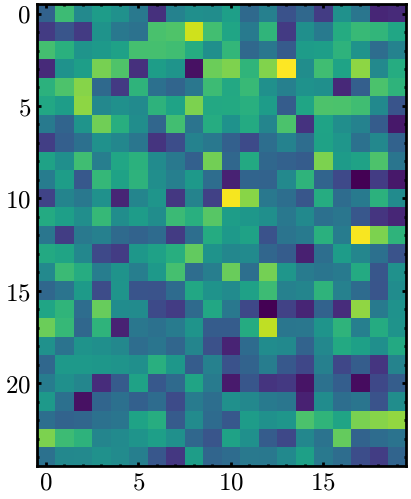

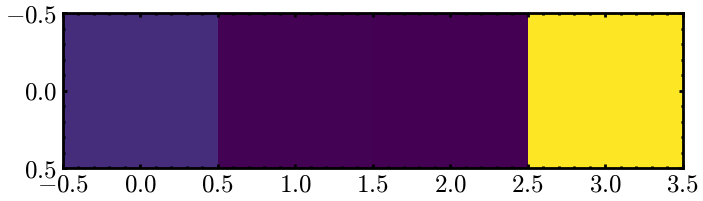

In [21]:
plt.imshow(dataframe["values"][0].reshape(25, 20))
plt.show()
plt.imshow([parm_vals[0]])
plt.show()

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animation():
    n = len(dataframe)

    # Create a set of arrays
    data = [dataframe["values"][i].reshape(25, 20) for i in range(n)]

    # Set up the figure, axis, and initial imshow object
    fig, axs = plt.subplots(2,1)
    im1 = axs[0].imshow(data[0], animated=True)
    im2 = axs[1].imshow([parm_vals[0]], animated=True)

    # Define the update function
    def update(frame):
        im1.set_array(data[frame])
        im2.set_array([parm_vals[frame]])
        _data = (dataframe.iloc[frame])

        text_ = f"fun: {_data['fun']**0.5:.1f}, nfev: {_data['nfev']}"
        axs[0].set_title(text_)
        return [im]

    # Create the animation object
    ani = FuncAnimation(fig, update, frames=len(data), blit=True)

    # Convert the animation to HTML and save it
    html_content = HTML(ani.to_jshtml()).data
    with open("animation.html", "w") as f:
        f.write(html_content)

    print("Animation saved as animation.html")


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
2023-09-04 10:10:01 | INFO | animation:save:1043 - Animation.save using <class 'matplotlib.animation.HTMLWriter'>
INFO:matplotlib.animation:Disabling savefig.bbox = 'tight', as it may cause frame size to vary, which is inappropriate for animation.
2023-09-04 10:10:01 | INFO | animation:save:1058 - Disabling savefig.bbox = 'tight', as it may cause frame size to vary, which is inappropriate for animation.
DEBUG:matplotlib.animation:frame size in pixels is 800 x 600
2023-09-04 10:10:01 | DEBUG | animation:_adjust_frame_size:309 - frame size in pixels is 800 x 600
2023-09-04 10:11:21 | WARNING | animation:grab_frame:768 - Animation size has reached 20990940 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.
DEBUG:matplotlib.animation:MovieWriter: cle

Animation saved as animation.html


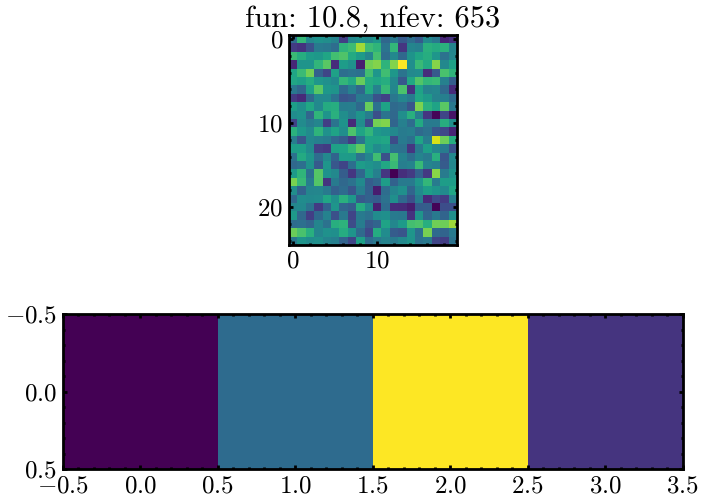

In [58]:
animation()